# Part 2

We start with the usual. Note the arguments that I use inside of `pd.read_csv`. What do they do?

In [232]:
# Part 2

import numpy as np
import pandas as pd

from pylab import mpl, plt

import scipy.optimize as sco

raw = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/etf-reproducible-finance.csv',
                  index_col=0, parse_dates=True).dropna() 

Note that you can just use `pct_change()` to calculate discrete returns. This is an example of **vectorization**. Your code is going to apply that function across all of the columns in the data frame. 

If you don't make the date the index column, though, you'll apply the percent change to the date column! You could, of course just apply percent change to specific columns. 

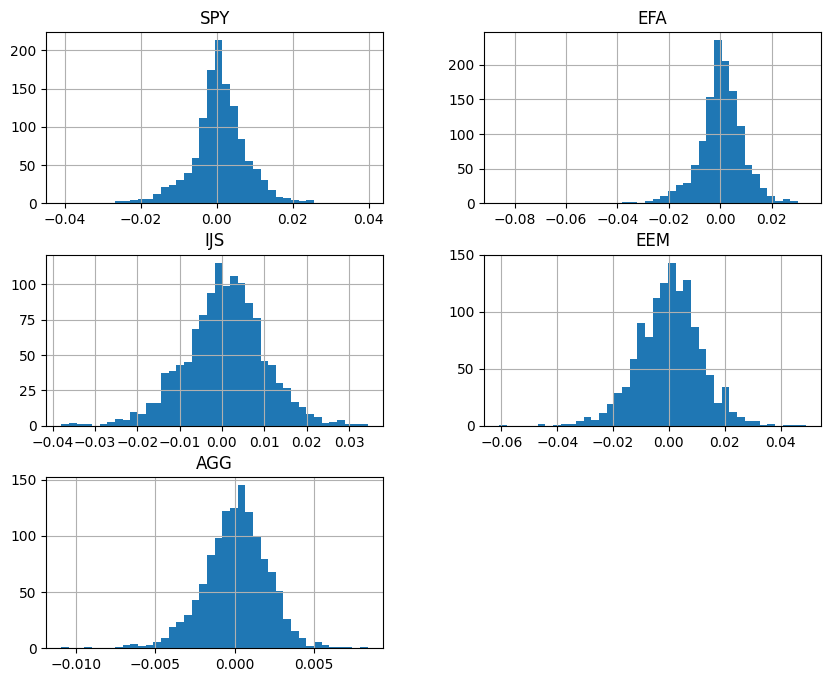

In [233]:
rets = raw.pct_change().dropna()

rets.hist(bins=40, figsize=(10, 8));

Always check your counts. Does the data make sense?

In [234]:
rets.describe()

,SPY,EFA,IJS,EEM,AGG
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.000610,0.000324,0.000617,0.000196,0.000078
std,0.007476,0.008985,0.009497,0.011567,0.002033
min,-0.040885,-0.085860,-0.037902,-0.060702,-0.010933
25%,-0.002778,-0.003991,-0.005131,-0.006799,-0.001094
50%,0.000632,0.000480,0.000771,0.000514,0.000180
75%,0.004652,0.005323,0.006543,0.007371,0.001375
max,0.039791,0.033264,0.034437,0.049041,0.008395


# Part 3

Let's set-up the optimization problem. I'm following along with my notes here. 

I have five assets. I annualize my daily returns. Again, this is **vectorization**. Every number in that data table is going to get multiplied by 252.

I then define the three functions that I need. I annualize my covariance matrix inside of the `port_vol` function. I could have done that above, like returns.

I define a **constraint** (cons) that all of the weights will sum to one. This is done using a **lambda** function, as explained in the notes. `x` will become the weights when the function is used. That constraint, when used inside of the optimizer will set the sum of the weights - 1 to be equal to 0. That is the same thing was the sum of the weights must be 1, or 100%.

I define **bounds** (bnds) that force my weights to be between 0 and 1. In other words, no shorting and no leverage allowed. This is where I use `noa = 5`. Five assets, five bounds.

Finally, I set up some initial weights for the optimizer to use. I use the "trick" described in the notes and create an equally-weighted portfolio to start.


In [235]:
## Part 3

noa = 5

ann_rets = rets.mean() * 252

def port_ret(weights):
    return np.sum(ann_rets * weights)

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)  

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  

bnds = tuple((0, 1) for x in range(noa))  

eweights = np.array(noa * [1. / noa,])  
eweights  

array([0.2, 0.2, 0.2, 0.2, 0.2])

Just like the notes. Finding the minimum negative (so, maximum) Sharpe ratio.

In [236]:
opt_max_sharpe = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons) 

opt_max_sharpe

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.5424499339237383
       x: [ 3.153e-01  2.033e-14  2.759e-13  2.072e-14  6.847e-01]
     nit: 10
     jac: [ 6.557e-05  1.963e+00  2.271e-02  3.731e+00 -3.016e-05]
    nfev: 63
    njev: 10

That `x` array are the weights. More on this below.

# Part 4

Let's do the same thing, but minimize portfolio volatility. Luckily, we've already define port vol!

In [237]:
# Part 4
opt_gmv = sco.minimize(port_vol, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)  

opt_gmv

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.02938548646490407
       x: [ 7.615e-02  1.171e-17  2.499e-02  0.000e+00  8.989e-01]
     nit: 8
     jac: [ 2.938e-02  3.611e-02  2.939e-02  5.965e-02  2.939e-02]
    nfev: 48
    njev: 8

The optimizer creates an object that I'm calling `opt_gmv`. Inside this object, are a variety of outputs. For example, the weights live in an array called `x`.

In [238]:
type(opt_gmv.x)

numpy.ndarray

You can pull these weights out. In this case, these are the weights, across the five ETFs, that give us the lowest volatility portfolio. They make sense: 89.89% of your assets would be in the AGG, the bond fund.

In [239]:
opt_gmv.x

array([7.61477866e-02, 1.17093835e-17, 2.49941061e-02, 0.00000000e+00,
       8.98858107e-01])

# Part 5

This section simply uses the weights from the optimizer to create **portfolio returns**. 

In [240]:
# Part 5
# Calculate the weighted stock returns

rets_max_sharpe_weighted = rets.mul(opt_max_sharpe.x, axis=1)
rets_max_sharpe_weighted['portfolio'] = rets_max_sharpe_weighted.sum(axis=1)

rets_gmv_weighted = rets.mul(opt_gmv.x, axis=1)
rets_gmv_weighted['portfolio'] = rets_gmv_weighted.sum(axis=1)

You can check the descriptive statistics. The counts match the counts above.

In [241]:
rets_gmv_weighted['portfolio'].describe()

count    1258.000000
mean        0.000132
std         0.001851
min        -0.008656
25%        -0.000857
50%         0.000246
75%         0.001253
max         0.008724
Name: portfolio, dtype: float64

# Part 6

There's a lot to this one part! Here are some steps to think about.

1. Get the Fama-French Data. These are the two CSV files that need to be cleaned. We saw in class that the easiest thing to do is just drag the file into the Explorer window in your code space. You'll then add/commit/push the CSV files to your repo, like any other file. 

You can right-click on the file in the Explorer to get the file path. Use this path inside of pd.read_csv. That will import the CSV file into a pandas Dataframe.

2. Pick an etf.  You can use YFinance or just use one from the other part of the lab.

3. This leaves you with three files: mom, ff, etf. You now have to look carefully at them:

Are the returns in the same units?
Dates? Are they same format?
Are all your returns monthly? Can we go from daily to monthly?

4. Once the data are cleaned, you need to combine the files. Try an inner merge of all three files using Date. An inner merge will just keeps Dates that are in all three files.

This final dataframe will look something like: Date ETF Mkt_rf SMB HML MOM

5. Finally, you run the Carhart four-factor regression and interpret the output.

I'm going to make the Date an index on import.

In [242]:
ff_clean = pd.read_csv('/workspaces/fin-data-analysis-spring2024/ff_clean.csv',
                  index_col=0)

In [243]:
ff_clean

,Mkt-RF,SMB,HML,RF
Date,,,,
192607,2.96,-2.56,-2.43,0.22
192608,2.64,-1.17,3.82,0.25
192609,0.36,-1.40,0.13,0.23
192610,-3.24,-0.09,0.70,0.32
192611,2.53,-0.10,-0.51,0.31
...,...,...,...,...
202310,-3.19,-3.87,0.19,0.47
202311,8.84,-0.02,1.64,0.44
202312,4.87,6.34,4.93,0.43


In [244]:
mom_clean = pd.read_csv('/workspaces/fin-data-analysis-spring2024/mom_clean.CSV',
                  index_col=0)

In [245]:
mom_clean

,mom
Date,
192701,0.36
192702,-2.14
192703,3.61
192704,4.30
192705,3.00
...,...
202310,1.73
202311,2.75
202312,-5.51


In [246]:
ff_clean = ff_clean.div(100)
mom_clean = mom_clean.div(100)
mom_clean

,mom
Date,
192701,0.0036
192702,-0.0214
192703,0.0361
192704,0.0430
192705,0.0300
...,...
202310,0.0173
202311,0.0275
202312,-0.0551


I'm going to merge these two now. Now, I set the index to be the Date column for both. Remember, the index is a "special" thing, not a "real" column in your data frame. Here's the syntax for **merging two dataframes on the index**.

By setting both the index values to `True`, this is like an `inner` merge. The index needs to be in both data frames. 

From ChatGPT:

> Yes, by default, pd.merge performs an inner merge. When you use left_index=True and right_index=True, it merges the two DataFrames on their indices, keeping only the rows with indices that appear in both DataFrames. This is similar to an inner join in SQL, where the result includes only the rows that have matching keys in both tables.

In [247]:
factors = pd.merge(ff_clean, mom_clean, left_index=True, right_index=True)
factors


,Mkt-RF,SMB,HML,RF,mom
Date,,,,,
192701,-0.0006,-0.0037,0.0454,0.0025,0.0036
192702,0.0418,0.0004,0.0294,0.0026,-0.0214
192703,0.0013,-0.0165,-0.0261,0.0030,0.0361
192704,0.0046,0.0030,0.0081,0.0025,0.0430
192705,0.0544,0.0153,0.0473,0.0030,0.0300
...,...,...,...,...,...
202310,-0.0319,-0.0387,0.0019,0.0047,0.0173
202311,0.0884,-0.0002,0.0164,0.0044,0.0275
202312,0.0487,0.0634,0.0493,0.0043,-0.0551


Finally, I'm going to convert these weird yyyymm dates into proper month-end dates. 

In [248]:
factors.index = pd.to_datetime(factors.index, format='%Y%m') + pd.offsets.MonthEnd()
factors


,Mkt-RF,SMB,HML,RF,mom
Date,,,,,
1927-01-31,-0.0006,-0.0037,0.0454,0.0025,0.0036
1927-02-28,0.0418,0.0004,0.0294,0.0026,-0.0214
1927-03-31,0.0013,-0.0165,-0.0261,0.0030,0.0361
1927-04-30,0.0046,0.0030,0.0081,0.0025,0.0430
1927-05-31,0.0544,0.0153,0.0473,0.0030,0.0300
...,...,...,...,...,...
2023-10-31,-0.0319,-0.0387,0.0019,0.0047,0.0173
2023-11-30,0.0884,-0.0002,0.0164,0.0044,0.0275
2023-12-31,0.0487,0.0634,0.0493,0.0043,-0.0551


Nice.

Now, let's pull in some ETF returns. I'll use the YFinance tools. I'm copying the set-up directly from the package page. Let's walk through what you can do with it. 

In [249]:
import yfinance as yf
import datetime

qval = yf.Ticker("QVAL")

This gets you some kind of ticker object that contains a bunch of stuff. I've brought in an ETF with the ticker QVAL. It is a quantitative value fund run by a firm called Alpha Architect.  

In [250]:
type(qval)


yfinance.ticker.Ticker

Like, information about the ETF.

In [251]:
qval.info

{'longBusinessSummary': 'The Adviser employs a multi-step, quantitative, rules-based methodology to identify a portfolio of approximately 50 to 200 undervalued U.S. equity securities with the potential for capital appreciation. A security is considered to be undervalued when it trades at a price below the price at which the Adviser believes it would trade if the market reflected all factors relating to the company’s worth. The fund may also invest up to 20% of its assets in cash and cash equivalents, other investment companies, as well as securities and other instruments.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 44.81,
 'open': 45.13,
 'dayLow': 44.2943,
 'dayHigh': 45.18,
 'regularMarketPreviousClose': 44.81,
 'regularMarketOpen': 45.13,
 'regularMarketDayLow': 44.2943,
 'regularMarketDayHigh': 45.18,
 'trailingPE': 6.391719,
 'volume': 36360,
 'regularMarketVolume': 36360,
 'averageVolume': 27200,
 'averageVolume10days': 21190,
 'averageDailyVolume10Day': 21190,
 'bid':

See the fund description above? Neat!

Now, let's bring in returns. YFinance brings in daily data, as you can see from the Date column. 2019 seems like a fun place to start.

Something strange - I had to use a start date of 2018-12-28 to get it to pull in 2018-12-31. I wanted that last December closing price, so that I can have a return for the first trading day of January. I'm playing with the start date and I think it is starting at that date, but not including it. Kind of like how some of the `.iloc` stuff works.

In [252]:
hist = qval.history(start="2018-12-28", end="2023-12-31")
hist[1:60]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2018-12-31 00:00:00-05:00,22.799542,22.804078,22.559070,22.720594,85600,0.000,0.0,0.0
2019-01-02 00:00:00-05:00,22.486477,23.176135,22.486477,23.071777,31300,0.000,0.0,0.0
2019-01-03 00:00:00-05:00,22.713339,22.849456,22.508257,22.508257,10700,0.000,0.0,0.0
2019-01-04 00:00:00-05:00,22.985572,23.339475,22.936569,23.330400,30900,0.000,0.0,0.0
2019-01-07 00:00:00-05:00,23.357627,23.956541,23.357627,23.811350,29600,0.000,0.0,0.0
2019-01-08 00:00:00-05:00,23.865796,24.038211,23.711530,24.023693,2700,0.000,0.0,0.0
2019-01-09 00:00:00-05:00,24.435674,24.618977,24.383043,24.471064,9100,0.000,0.0,0.0
2019-01-10 00:00:00-05:00,24.228770,24.443834,24.192472,24.443834,1600,0.000,0.0,0.0
2019-01-11 00:00:00-05:00,24.328588,24.503725,24.328588,24.488298,900,0.000,0.0,0.0


You can change that and get just monthly data. But, it looks like the start of the month to me. I like end of month, so that I can calculate returns from the close.

In [253]:
hist2 = qval.history(start="2018-11-01", end="2023-12-31", interval="1mo")
hist2[1:30]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2018-12-01 00:00:00-05:00,26.342982,26.577222,21.495116,22.557304,490100,0.180,0.0,0.0
2019-01-01 00:00:00-05:00,22.486479,26.025513,22.486479,26.025513,197100,0.000,0.0,0.0
2019-02-01 00:00:00-05:00,25.995561,27.223334,25.671605,26.516436,339300,0.000,0.0,0.0
2019-03-01 00:00:00-05:00,26.896655,27.087220,25.181586,26.038214,239700,0.085,0.0,0.0
2019-04-01 00:00:00-04:00,26.321519,27.704947,26.321519,27.248960,115900,0.000,0.0,0.0
2019-05-01 00:00:00-04:00,27.359092,27.359092,23.420875,23.436348,339200,0.000,0.0,0.0
2019-06-01 00:00:00-04:00,23.814970,25.599773,23.697561,25.522409,331900,0.146,0.0,0.0
2019-07-01 00:00:00-04:00,26.097041,26.545412,25.557166,26.011942,224100,0.000,0.0,0.0
2019-08-01 00:00:00-04:00,26.060444,26.060444,23.243940,24.054668,218400,0.000,0.0,0.0


Here's another way to download just the price data. I think this method is a bit more straightforward. OHLC = Open High Low Close.

In [254]:
qval_ohlc = yf.download("QVAL", start="2018-12-28", end="2024-01-03")
qval_ohlc[1:60]

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,25.125000,25.129999,24.860001,25.038000,22.720598,85600
2019-01-02,24.780001,25.540001,24.780001,25.424999,23.071779,31300
2019-01-03,25.030001,25.180000,24.804001,24.804001,22.508255,10700
2019-01-04,25.330000,25.719999,25.275999,25.709999,23.330400,30900
2019-01-07,25.740000,26.400000,25.740000,26.240000,23.811348,29600
2019-01-08,26.299999,26.490000,26.129999,26.474001,24.023689,2700
2019-01-09,26.927999,27.129999,26.870001,26.966999,24.471058,9100
2019-01-10,26.700001,26.937000,26.660000,26.937000,24.443838,1600
2019-01-11,26.809999,27.003000,26.809999,26.986000,24.488300,900


I'm going to check the end of this file too.

In [255]:
qval_ohlc.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-26,40.759998,41.000000,40.650002,40.875000,40.742126,11900
2023-12-27,40.810001,40.981998,40.759998,40.810001,40.677341,45300
2023-12-28,40.860001,40.860001,40.630001,40.660000,40.527824,43900
2023-12-29,40.730000,40.730000,40.369999,40.490002,40.358379,70200
2024-01-02,40.240002,40.720001,40.240002,40.549999,40.418182,33900


OK, the 29th of December really is the end date for the year. Isn't this fun!!!!???

`Date` is again the index for this data frame. You don't got the dividend and capital gains info, though.

Now, notice the Adj Close. This stands for **Adjusted Close**. The adjusted close is going to take dividends (and other things) into account. You can read about it here: <https://finance.zacks.com/stock-return-using-adjusted-closing-price-11628.html> and at <https://www.investopedia.com/terms/a/adjusted_closing_price.asp>.

Let's start by keeping just month-end observations. Then, I'll calculate monthly returns from the month-end closing adjusted prices. 

Notice how I keep the month-end data. I group by 'index.year' and 'index.month'. Remember, 'index' is our 'Date'. This is putting our data into groups. I then keep `.tail(1)`, or the last value in that group.


In [256]:
qval_ohlc_m = qval_ohlc.groupby([qval_ohlc.index.year, qval_ohlc.index.month]).tail(1)
qval_ohlc_m.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,25.125000,25.129999,24.860001,25.038000,22.720598,85600
2019-01-31,28.469999,28.680000,28.469999,28.680000,26.025515,4900
2019-02-28,29.150000,29.260000,29.139999,29.221001,26.516438,1100
2019-03-29,28.760000,28.760000,28.570000,28.694000,26.115826,11900
2019-04-30,30.010000,30.100000,29.683001,29.938999,27.248959,2600


I now I can calculate returns as usual.

In [257]:
qval_ohlc_m['qval_ret'] = qval_ohlc_m['Adj Close'].pct_change()
qval_ohlc_m.head()

/tmp/ipykernel_3924/1639116209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qval_ohlc_m['qval_ret'] = qval_ohlc_m['Adj Close'].pct_change()


,Open,High,Low,Close,Adj Close,Volume,qval_ret
Date,,,,,,,
2018-12-31,25.125000,25.129999,24.860001,25.038000,22.720598,85600,NaN
2019-01-31,28.469999,28.680000,28.469999,28.680000,26.025515,4900,0.145459
2019-02-28,29.150000,29.260000,29.139999,29.221001,26.516438,1100,0.018863
2019-03-29,28.760000,28.760000,28.570000,28.694000,26.115826,11900,-0.015108
2019-04-30,30.010000,30.100000,29.683001,29.938999,27.248959,2600,0.043389


Ugh, I can't stand that warning. I'm coming from other languages, where the column selection technique that I like to use is just fine. Here's how you can get rid of that warning by using `.iloc`.

Here ChatGPT:

> In this code, .loc[:, 'qval_ret'] is used to explicitly select the qval_ret column for all rows in the qval_ohlc_m DataFrame. This approach ensures that the assignment is done directly on the DataFrame, avoiding the warning about setting a value on a copy of a slice.

In [258]:
qval_ohlc_m.loc[:, 'qval_ret'] = qval_ohlc_m['Adj Close'].pct_change()
qval_ohlc_m.head()

,Open,High,Low,Close,Adj Close,Volume,qval_ret
Date,,,,,,,
2018-12-31,25.125000,25.129999,24.860001,25.038000,22.720598,85600,NaN
2019-01-31,28.469999,28.680000,28.469999,28.680000,26.025515,4900,0.145459
2019-02-28,29.150000,29.260000,29.139999,29.221001,26.516438,1100,0.018863
2019-03-29,28.760000,28.760000,28.570000,28.694000,26.115826,11900,-0.015108
2019-04-30,30.010000,30.100000,29.683001,29.938999,27.248959,2600,0.043389


I think that you could do this daily to monthly return calculation using `resample` from `pandas`. But, I ran into trouble with it not understanding that the end of the month for trading isn't necessarily the end of the actual month. This way seemed easier. 

I'm just going to keep `qval_ret` now. I'm ready to merge with the factor data.

In [259]:
qval_ret = qval_ohlc_m[['qval_ret']].dropna()
qval_ret

,qval_ret
Date,
2019-01-31,0.145459
2019-02-28,0.018863
2019-03-29,-0.015108
2019-04-30,0.043389
2019-05-31,-0.139918
...,...
2023-09-29,0.003217
2023-10-31,-0.048450
2023-11-30,0.068192


Let's just keep the 2019 through 2023.

In [260]:
qval_ret = qval_ret[(qval_ret.index.year >= 2019) & (qval_ret.index.year <= 2023)]
qval_ret


,qval_ret
Date,
2019-01-31,0.145459
2019-02-28,0.018863
2019-03-29,-0.015108
2019-04-30,0.043389
2019-05-31,-0.139918
2019-06-28,0.094866
2019-07-31,0.013729
2019-08-30,-0.075245
2019-09-30,0.064479


Cool - let's merge.

In [261]:
all = pd.merge(factors, qval_ret, left_index=True, right_index=True)
all


,Mkt-RF,SMB,HML,RF,mom,qval_ret
Date,,,,,,
2019-01-31,0.0840,0.0290,-0.0046,0.0021,-0.0868,0.145459
2019-02-28,0.0340,0.0205,-0.0267,0.0018,0.0086,0.018863
2019-04-30,0.0397,-0.0174,0.0215,0.0021,-0.0297,0.043389
2019-05-31,-0.0694,-0.0132,-0.0237,0.0021,0.0756,-0.139918
2019-07-31,0.0119,-0.0193,0.0048,0.0019,0.0289,0.013729
2019-09-30,0.0143,-0.0096,0.0675,0.0018,-0.0681,0.064479
2019-10-31,0.0206,0.0029,-0.0191,0.0016,0.0015,0.052046
2019-12-31,0.0277,0.0073,0.0175,0.0014,-0.0177,0.013525
2020-01-31,-0.0011,-0.0311,-0.0625,0.0013,0.0598,-0.063445


Can you believe that we finally got here? Our data is clean. It is ready. We can run a regression and actually do some finance. 

You'll have to do a `pip install statsmodels` to get the package. Then, import like I do below.

Remember, you need to `pip` certain packages into every new code space, if the code space doesn't come with it. I was surpirsed this one was missing. 

In [262]:
all.describe()

,Mkt-RF,SMB,HML,RF,mom,qval_ret
count,42.000000,42.000000,42.000000,42.000000,42.00000,42.000000
mean,0.014648,-0.002455,-0.002555,0.001531,-0.00214,0.015057
std,0.056694,0.027485,0.049566,0.001577,0.04897,0.086231
min,-0.133900,-0.059400,-0.138700,0.000000,-0.16010,-0.280534
25%,-0.023650,-0.019050,-0.023275,0.000100,-0.02445,-0.022904
50%,0.026300,-0.001200,-0.004550,0.001350,0.00805,0.024400
75%,0.046225,0.016625,0.020050,0.002250,0.02675,0.053293
max,0.136500,0.058000,0.127500,0.004700,0.07970,0.161237


In [263]:
all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 2019-01-31 to 2023-11-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Mkt-RF    42 non-null     float64
 1   SMB       42 non-null     float64
 2   HML       42 non-null     float64
 3   RF        42 non-null     float64
 4   mom       42 non-null     float64
 5   qval_ret  42 non-null     float64
dtypes: float64(6)
memory usage: 2.3 KB


I'm going to rename these columns. I was trying to run the regression and `smf` didn't like some of hte names. That dash I think.

In [264]:
all.rename(columns={'Mkt-RF': 'mkt_rf'}, inplace=True)
all.rename(columns={'SMB': 'smb'}, inplace=True)
all.rename(columns={'HML': 'hml'}, inplace=True)
all.rename(columns={'RF': 'rf'}, inplace=True)





Now, here's something really fun. I can't get my code to recognize `mom` as a variable/column name. Let's see why.

In [265]:
all.columns

Index(['mkt_rf', 'smb', 'hml', 'rf', 'mom   ', 'qval_ret'], dtype='object')

Awesome. The CSV file brought in a bunch of white space on import. See how it looks like `mom` everywhere? But when I print the actual columns it isn't really `mom`.

This will get rid of the white space for all columns.

In [266]:
all.columns = [col.strip() for col in all.columns]


In [267]:
all.columns

Index(['mkt_rf', 'smb', 'hml', 'rf', 'mom', 'qval_ret'], dtype='object')

In [268]:
all.head()

,mkt_rf,smb,hml,rf,mom,qval_ret
Date,,,,,,
2019-01-31,0.0840,0.0290,-0.0046,0.0021,-0.0868,0.145459
2019-02-28,0.0340,0.0205,-0.0267,0.0018,0.0086,0.018863
2019-04-30,0.0397,-0.0174,0.0215,0.0021,-0.0297,0.043389
2019-05-31,-0.0694,-0.0132,-0.0237,0.0021,0.0756,-0.139918
2019-07-31,0.0119,-0.0193,0.0048,0.0019,0.0289,0.013729


In [269]:
import statsmodels.formula.api as smf

model = smf.ols(formula='qval_ret ~ mkt_rf + smb + hml + mom', data = all)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               qval_ret   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     87.93
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           2.25e-18
Time:                        01:54:20   Log-Likelihood:                 93.232
No. Observations:                  42   AIC:                            -176.5
Df Residuals:                      37   BIC:                            -167.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.005     -0.053      0.9

So, can you tell what this fund does? What do you think?